In [1]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import dask
from distributed import Client, progress
import dask.async
import dask.diagnostics

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

# Crossvalidation of gini-signature on the GTEx dataset
In this document, we perform a 10-fold cross-validation of signature generation with gini-index. 

## Use dask for parallel computation

In [2]:
c = Client("10.114.185.14:8786")

In [3]:
expr_file = "../data/gtex/exprs.npy"
target_file = "../data/gtex/target.csv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits=10)
signature_generator = GiniSignatureGenerator
signature_tester = BioQCSignatureTester

In [4]:
expr = np.load(expr_file)
target = np.genfromtxt(target_file, dtype=str, delimiter=',')

In [63]:
target = ['Intestine' if label in ['Colon', 'Small Intestine'] else label for label in target]
target = ['Muscle' if label in ['Heart', 'Muscle'] else label for label in target]
target = np.array(target)
unambiguous = ['Intestine', 'Muscle', 'Blood', 'Brain', 'Kidney', 'Liver', 'Ovary', 'Pancreas', 'Testis']
unambiguous_inds = np.array([i for (i, label) in enumerate(target) if label in unambiguous])

In [64]:
expr_ua = expr[:, unambiguous_inds]
target_ua = target[unambiguous_inds]
expr_ua_file = '../data/gtex/exprs_unambiguous.npy'
target_ua_file = "../data/gtex/target_unambiguous.csv"
np.save(expr_ua_file, expr_ua)
np.savetxt(target_ua_file, target_ua, delimiter=",", fmt="%s")

In [101]:
sig_list, res_list = cross_validate_signatures(expr_ua_file, target_ua_file, signature_generator, signature_tester, splitter,
                                               sg_kwargs={"min_gini": .85, "max_rk": 3})


This is the dask compute graph executed internally: 

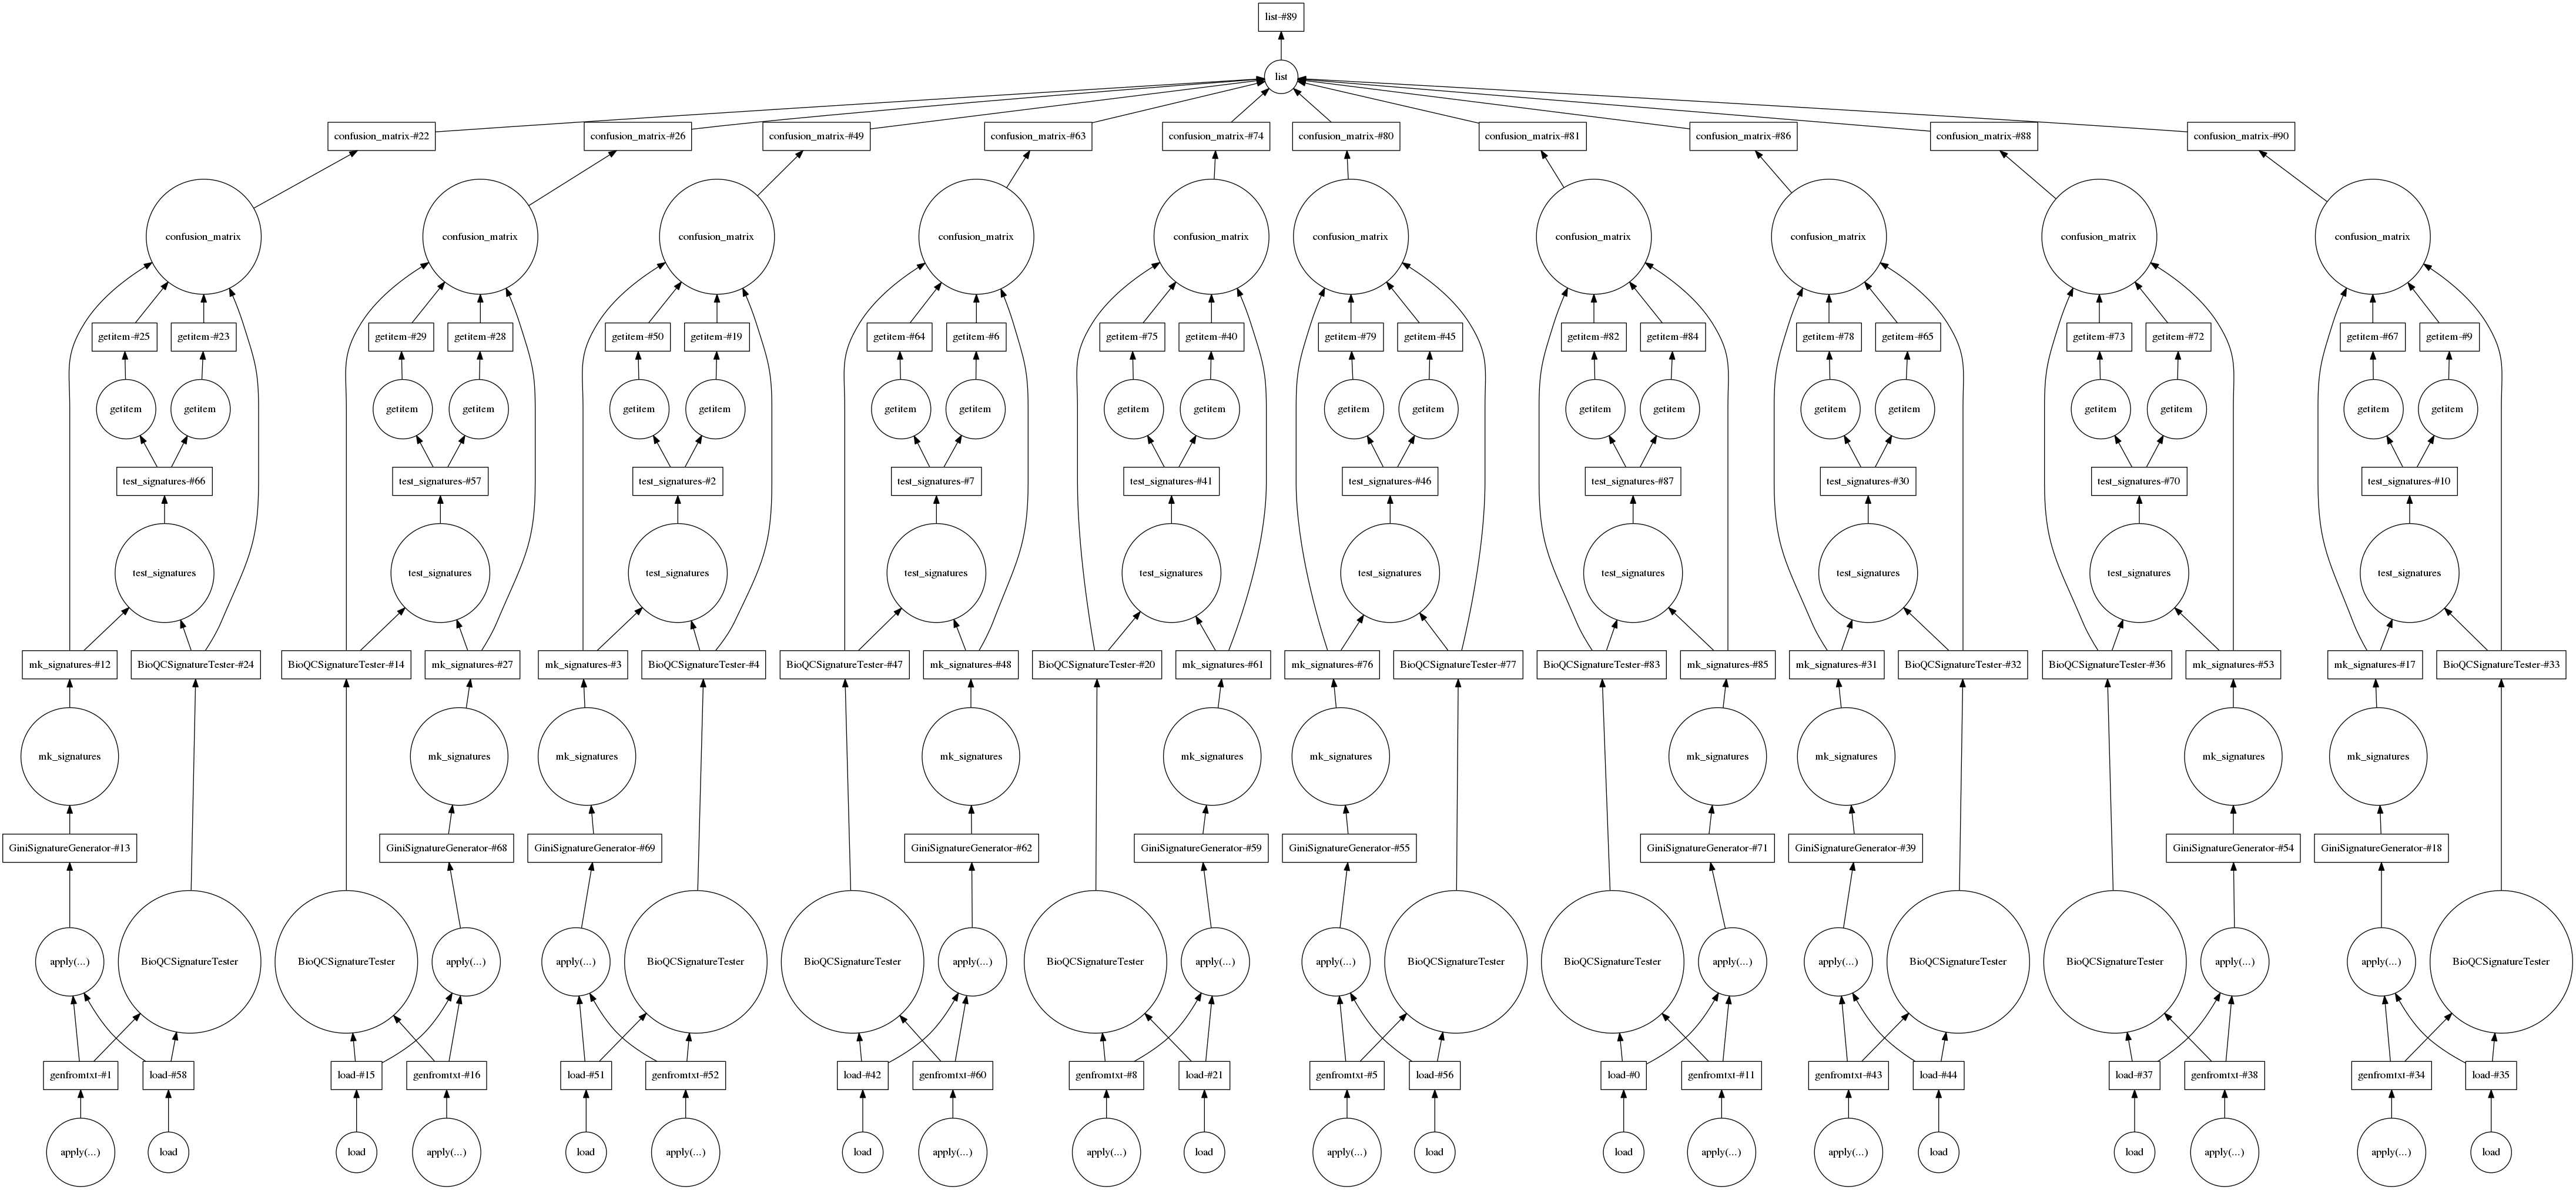

In [102]:
res_list.visualize()

Do the actual computation:

In [103]:
sig_f, res_f = c.compute([sig_list, res_list], sync=False)

In [104]:
progress([sig_f, res_f])

In [105]:
signatures = sig_f.result()

In [106]:
cms = res_f.result()

In [107]:
# import pickle
# pickle.dump([signatures, cms], open("../results/validate_gini_res.pickle", 'w+b'))

## Signature overlap between the folds
The box-plot shows the overlap of the signatures between the different folds. A high jaccard index indicates stability of the signatures between the folds. 

In [108]:
pairwise_jaccard = pairwise_jaccard_ind(signatures)

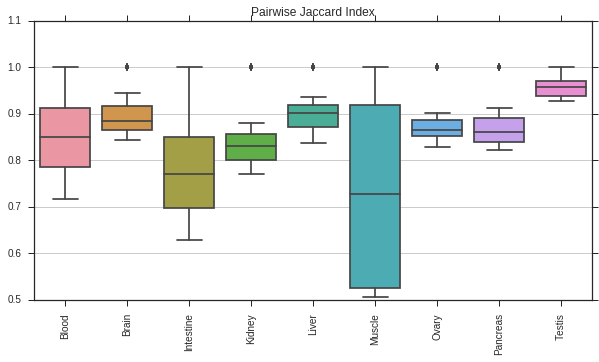

In [109]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(pairwise_jaccard)
sns.boxplot(data=data, ax=ax)
ax.set_title("Pairwise Jaccard Index")
ax.set_xticklabels(data.columns, rotation=90);

## Confusion Matrix
The confusion matrix shows which tissues tend to be *confused* with others. For example, we can see that it is difficult to differntiate between *colon* and *small intestine*. 

The confusion matrix below shows the average counts over the 10 folds per tissue. That means the matrix is not corrected for the number of samples per tissue. 

In [110]:
conf_mat_mean = np.mean(np.array(cms), axis=0)

In [111]:
sig_labels = BioQCSignatureTester.sort_signatures(signatures[0])

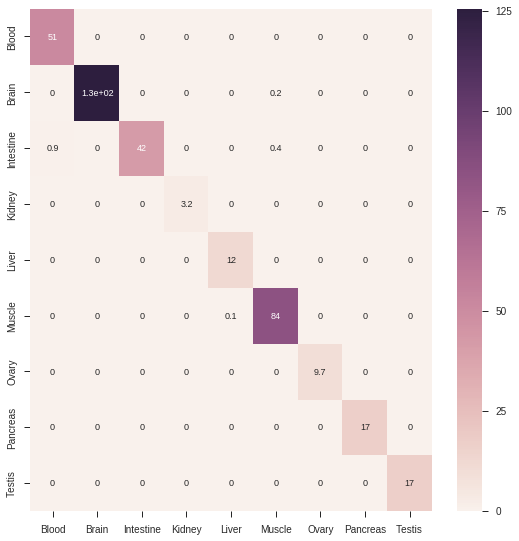

In [112]:
fig, ax = subplots(figsize=(9, 9))
sns.heatmap(conf_mat_mean, ax=ax, xticklabels=sig_labels, yticklabels=sig_labels, annot=True,annot_kws={"size": 9});

Based on this observation, we: 
    
* collapse colon and small intestine
* remove Esophagus
* remove Breast 
    

## Performance Measures per Tissue
Below, we show the Sensitiviy, Specificity and Matthews Correlation Coefficient for the different tissues. 

In [113]:
sens = performance_per_tissue(cms, sig_labels, pm.sens)
spec = performance_per_tissue(cms, sig_labels, pm.spec)
prec = performance_per_tissue(cms, sig_labels, pm.prec_pos)
mcc = performance_per_tissue(cms, sig_labels, pm.mcc)

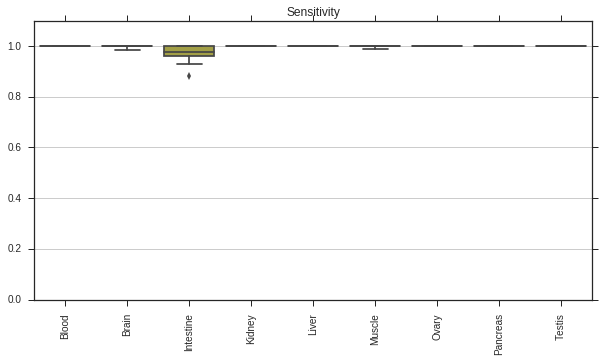

In [114]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(sens)
sns.boxplot(data=data, ax=ax)
ax.set_title("Sensitivity")
ax.set_xticklabels(data.columns, rotation=90);
ax.set_ylim((0, 1.1));

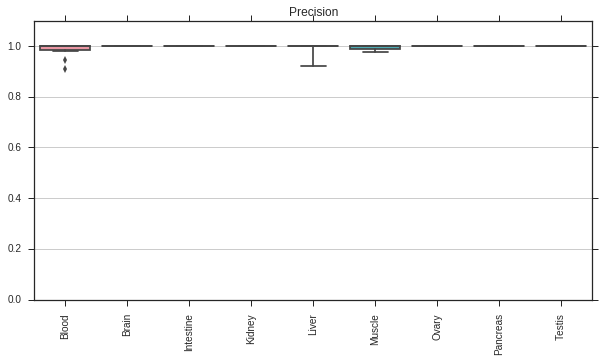

In [115]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(prec)
sns.boxplot(data=data, ax=ax)
ax.set_title("Precision")
ax.set_xticklabels(data.columns, rotation=90);
ax.set_ylim((0, 1.1));

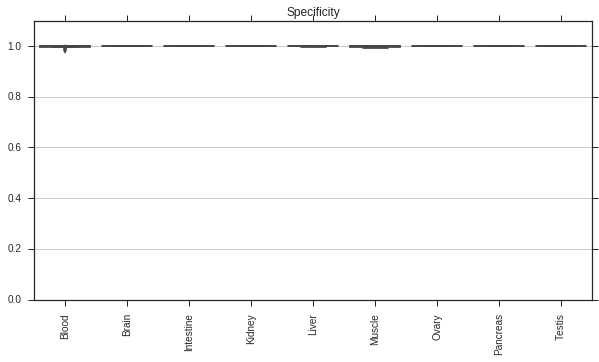

In [116]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(spec)
sns.boxplot(data=data, ax=ax)
ax.set_title("Specificity")
ax.set_xticklabels(data.columns, rotation=90);
ax.set_ylim((0, 1.1));

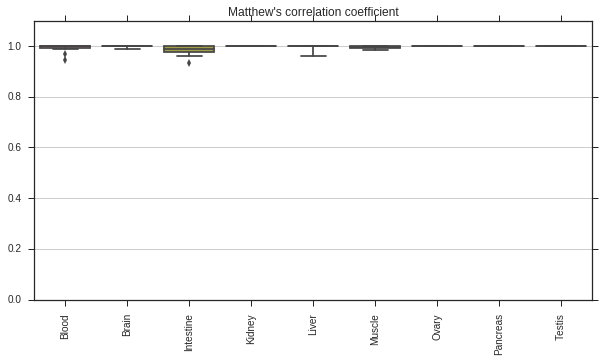

In [117]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(mcc)
sns.boxplot(data=data, ax=ax)
ax.set_title("Matthew's correlation coefficient")
ax.set_xticklabels(data.columns, rotation=90);
ax.set_ylim((0, 1.1));

## average performance

In [118]:
np.mean(list(mcc.values()))

0.99581717044858353